# Proyecto Final Data Scients 

## Descripcion del proyecto 
La compañia de telecomunicaciones Interconnect requiere un modelo predictivo para pronosticar cuando un cliente esta pensando dejar de usar sus servicios para que con ello pueda brindarle promociones o novedades para poder mantenerlo en el servicio, se usaran 4 diferentes data set que contienen informacion sobre las clientes actuales y alguno que ya han dejado el servicio, en los dataset tenemos informacion del contrato, informacion personal del cliente, los servicios con los que cuenta o contaba y si tenia multiples lineas telefonicas.

## Objetivo
Entrenar y evaluar diferentes modelos buscando el mejor score para la metrica AUR-ROC con set de pruebas.

In [ ]:
# Importacion de librerias principales
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, accuracy_score
#from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
# Lectura de dataframe y guardar en variables
contract = pd.read_csv('/data/contract.csv')
personal = pd.read_csv('/data/personal.csv')
internet = pd.read_csv('/data/internet.csv')
phone = pd.read_csv('/data/phone.csv')

In [ ]:
# Funcion para hacer exploracion de datos basico 
def eda_basica(df):
    print("Primeras 5 filas del DataFrame:")
    print(df.head())
    print("\n")
    print("Información general del DataFrame:")
    print(df.info())
    print("\n")
    print("Estadísticas descriptivas:")
    print(df.describe(include='all', datetime_is_numeric=True))  # incluye categóricas y fechas
    print("\n")
    print("Valores nulos por columna:")
    print(df.isna().sum())
    print("\n")


In [ ]:
eda_basica(contract)

Primeras 5 filas del DataFrame:
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65  


Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 704

### Analisis del dataframe
1. Columnas
    - ID unico del cliente
    - Fecha de inicio del servicio y de termino
    - Tipo de contrato
    - Si la facturacion es sin papel
    - Metodo de pago que usa el cliente
    - Cargos del mens
    - Cargos totales al corte de los datos
2. Informacion del dataframe
    - Las columnas con fecha no estan con tipo de dato date.time
    - TotalCharges seria recomendable convertirlo en flotante
3. Estadistica
    - El tipo de contrato por mes es el mas usado
    - La mayoria de los usuarios usan facturacion sin papel
    - el metodo de pago mas usado es cheque
4. Nulos
    - No hay datos nulos en la tabla
  
### Observaciones
Se tiene que hacer preprocesamiento de la tabla ya que hay algunas columnas con tipo de dato erroneo

Como el objetivo es detectar el abandono de un cliente podriamos dejar fuera la columna de PaperlessBilling ya que no muy relevante pero haremos despues una evaluacion de correlacion para saber que tanto afecta el abandono o no.

  

In [ ]:
eda_basica(personal)

Primeras 5 filas del DataFrame:
   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No


Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


Estadísticas descriptivas:
        customerID gender  SeniorCitizen Partner Dependents
count         7043   7043    7043.000000  

### Analisis del dataframe
1. Columnas
    - ID unico del cliente
    - ¿SeniorCitizen?
    - ¿Partner?
    - Dependientes, si tiene alguna persona que dependa del cliente 
2. Informacion del dataframe
    - No se encontro ningun problema en la informacion general 
3. Estadistica
    - El genero masculino es el genero que mas esta dentro de los clientes
    - La mayoria de los clientes no tiene un dependiente 
4. Nulos
    - No hay datos nulos en la tabla
  
### Observaciones
Se agregaran preguntas a la lista para saber la contexto de las columnas SeniorCitizen y Partner

Como el objetivo es detectar el abandono de un cliente podriamos dejar fuera algunas de las columnas para que el modelo que se vaya a crear pueda ser mas eficiente pero esto lo confirmaremos despues con una revision en la correlacion 

In [ ]:
eda_basica(internet)

Primeras 5 filas del DataFrame:
   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No  


Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 


### Analisis del dataframe
1. Columnas
    - ID unico del cliente
    - Tipo de servicio de internet 
    - Si cuenta con el servicio de Seguridad en linea
    - Si cuenta con el servicio de Respaldo
    - Si cuenta con el servicio de Proteccion de dispositivo
    - Si cuenta con el servicio de Soporte tecnico
    - Si cuenta con el servicio de Streaming TV
    - Si cuenta con el servicio de Streaming de peliculas
2. Informacion del dataframe
    - No se encontro ningun problema en la informacion general 
3. Estadistica
    - El tipo de internet que mas se usa es Fibra optica
    - La mayoria no usa el servicio de seguridad online
    - La mayoria no usa el servicio de respaldo online
    - La mayoria no usa el servicio de Proteccion de dispositivo
    - La mayoria no usa el servicio de Soporte tecnico
    - La mayoria no usa el servicio de Streaming TV
    - La mayoria no usa el servicio de Streaming de peliculas 
4. Nulos
    - No hay datos nulos en la tabla
  
### Observaciones
Todas las columnas de este dataframe nos pueden brindar informacion importante sobre el comportamiento de los clientes ya que si alguno tenia alguin servicio extra contratado y abandono el servicio podemos suponer que no estaba satisfecho con los servicios

In [ ]:
eda_basica(phone)

Primeras 5 filas del DataFrame:
   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes


Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


Estadísticas descriptivas:
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     0020-INWCK            No
freq             1          3390


Valores nulos por columna:
customerID       0
MultipleLines    0
dtype: int64




### Anaisis del dataframe
1. Columnas
    - ID unico del cliente
    - Si cuenta con multiples lineas
2. Informacion del dataframe
    - No se encontro ningun problema en la informacion general 
3. Estadistica
    - La mayoria no cuenta con multiples lineas 
4. Nulos
    - No hay datos nulos en la tabla
  
### Observaciones
Solo contamos con una columna pero igualmente se revisara la importancia con la corelacion con el abandono de los clientes 

## Limpieza y union de datos

Para mejorar el analisis y procesamiento de los datos se van a unir en un solo dataframe y se hara una primera limpieza para el EDA

In [ ]:
# Unir dataframes en una nueva variable 
df = contract.merge(internet, how='left', on='customerID')
df = df.merge(personal, how='left', on='customerID')
df = df.merge(phone, how='left', on='customerID')

In [ ]:
# Crear columna de objetivo 
df['Target'] = (df['EndDate'] != "No").astype("int")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


In [ ]:
# Eliminar algunas filas 11 filas vacias de TotalCharges
df = df[df['TotalCharges'] != ' ']

In [ ]:
# Convertimos la columna a flotante
df['TotalCharges'] = df['TotalCharges'].astype('float')

In [ ]:
# Pasamos a 1 y 0 las columnas para poder ver mejor la relacion 
yn_columns = ['PaperlessBilling', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Partner','Dependents', 'MultipleLines']

#asignar 0 a todos los usuarios que no tengan cierto servicio y cambiar tipo de dato
for col in yn_columns:
  df.loc[df[col] == 'Yes', col] = 1
  df.loc[df[col] != 1, col] = 0

  df[col] = df[col].astype('int')

## EDA

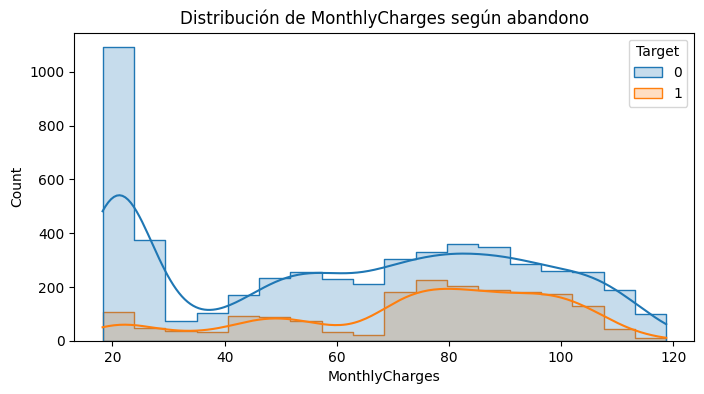

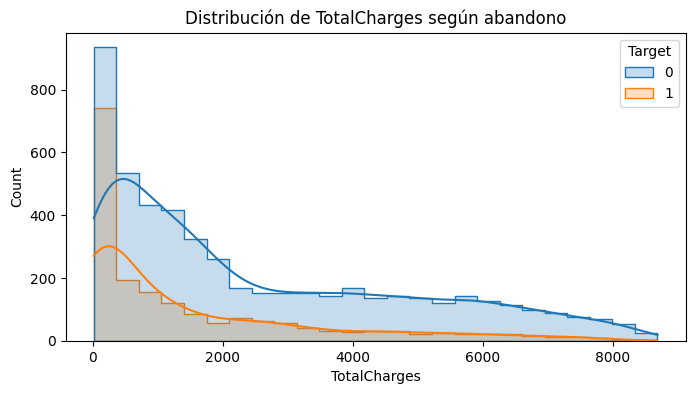

In [ ]:
# Analisis de distribucion de columnas numericas 
for col in ['MonthlyCharges', 'TotalCharges']:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, hue='Target', kde=True, element='step')
    plt.title(f'Distribución de {col} según abandono')
    plt.show()

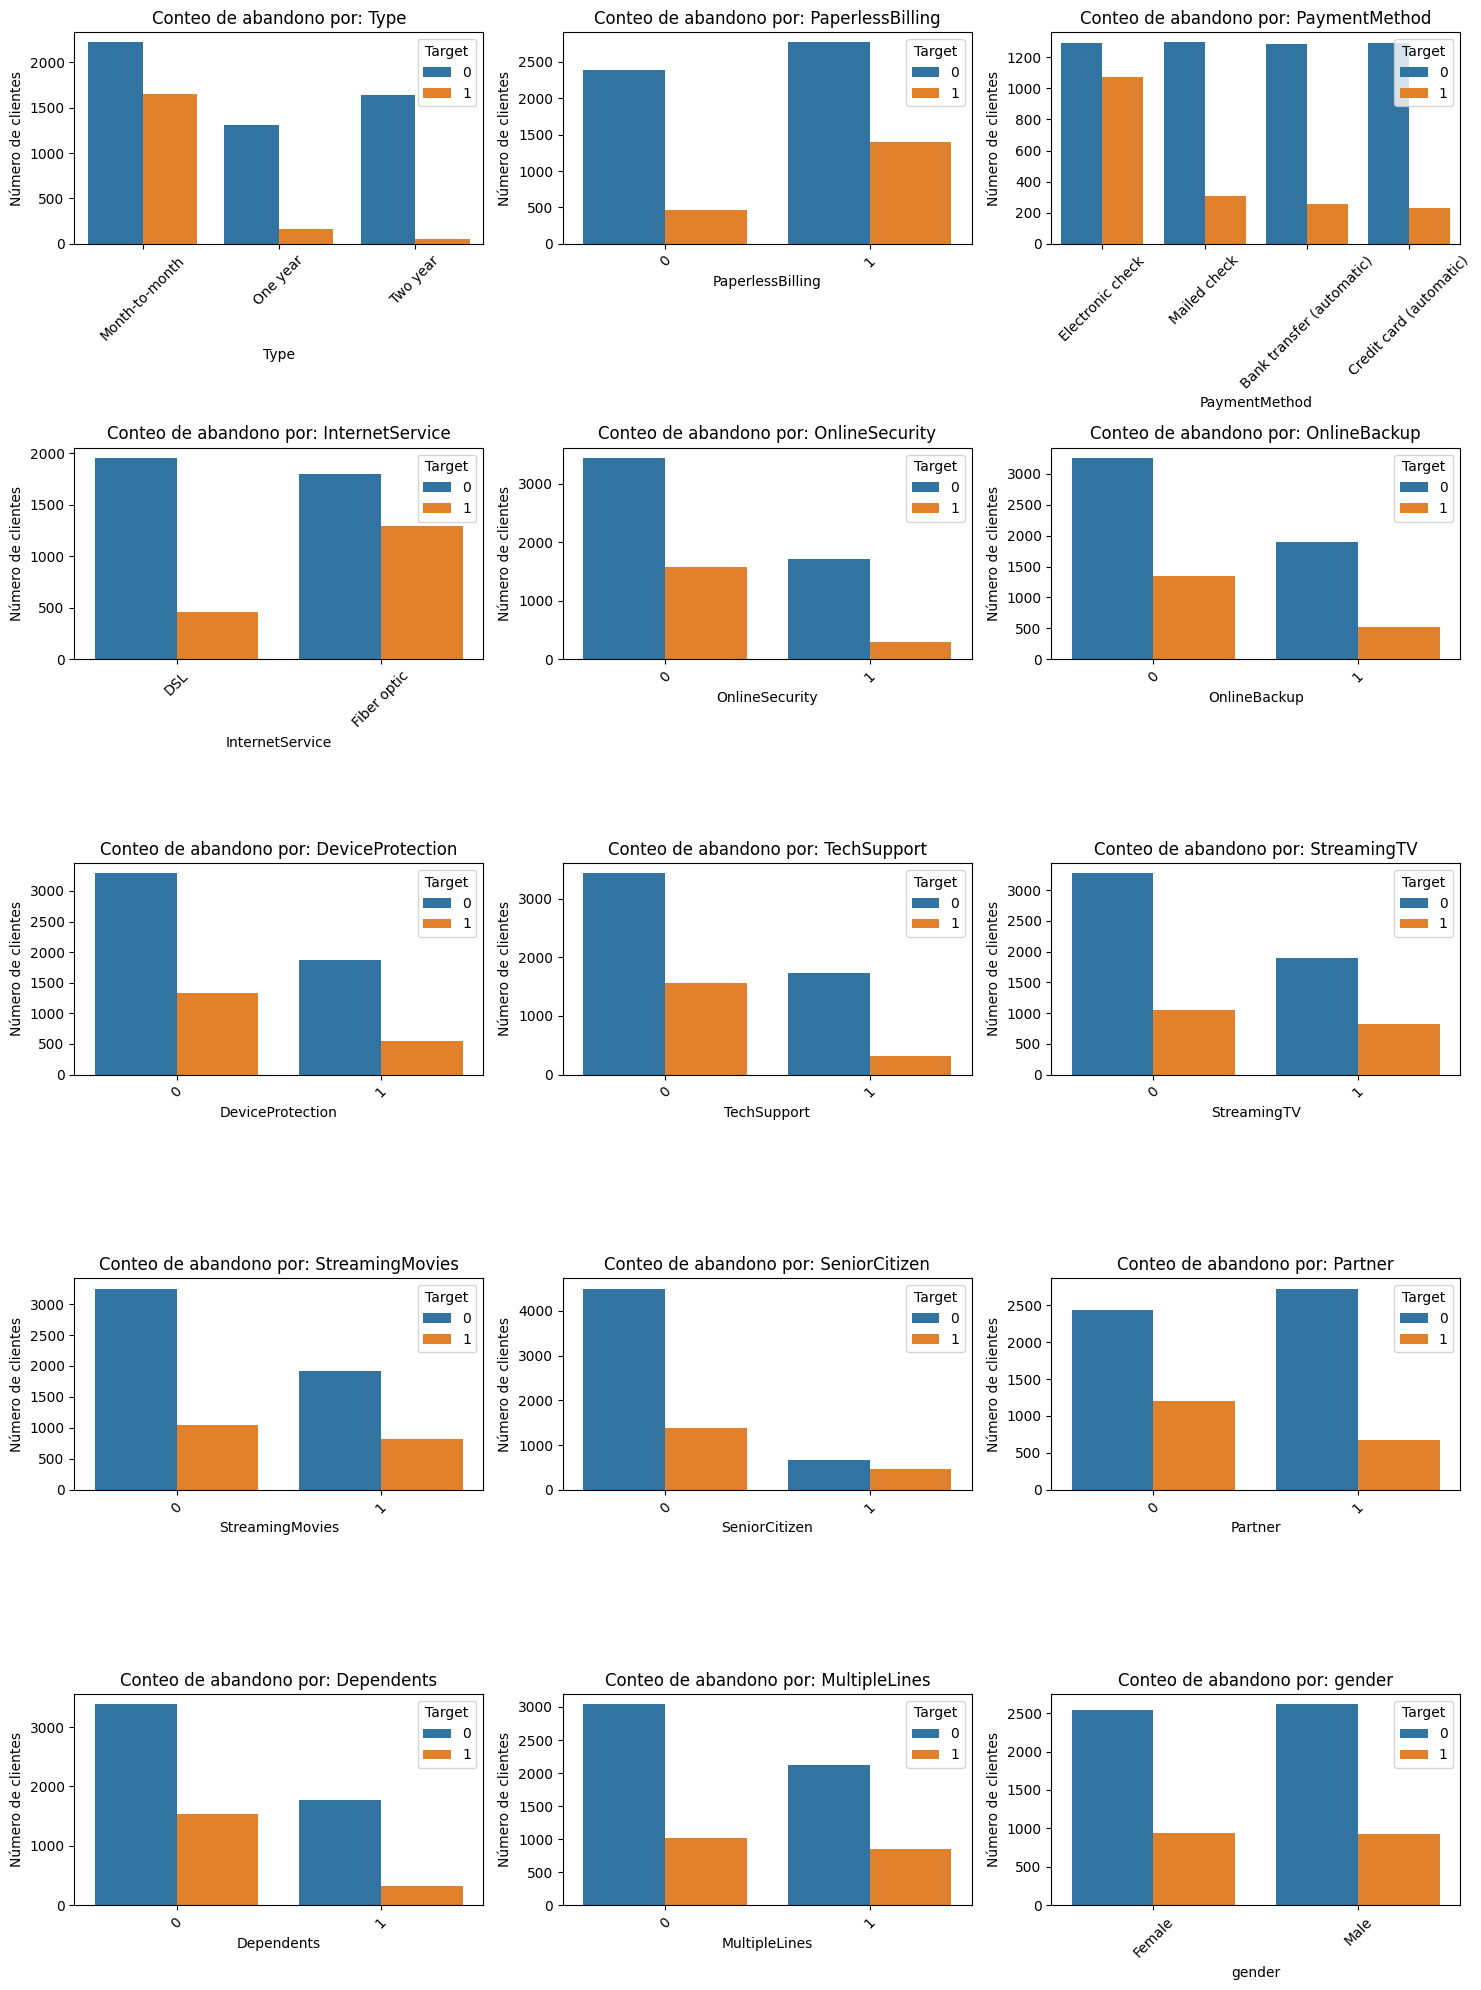

In [ ]:
# Lista de columnas categóricas que quieres graficar
import matplotlib.pyplot as plt
import seaborn as sns

# Lista personalizada de columnas categóricas
cols_a_graficar = [
    'Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'SeniorCitizen', 'Partner',
    'Dependents', 'MultipleLines', 'gender'
]

# Parámetros para subplots
n_cols = 3
n_rows = (len(cols_a_graficar) + n_cols - 1) // n_cols

# Crear figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

# Graficar cada variable
for i, col in enumerate(cols_a_graficar):
    sns.countplot(data=df, x=col, hue='Target', ax=axes[i])
    axes[i].set_title(f'Conteo de abandono por: {col}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylabel('Número de clientes')

plt.tight_layout()
plt.show()

In [ ]:
# Filtrar solo columnas numéricas
numericas = df.select_dtypes(include=['number'])

# Calcular correlación 
correlaciones = numericas.corr()['Target'].sort_values(ascending=False)

# Mostrar el resultado
print("Correlación de cada variable con el abandono (Target):\n")
print(correlaciones)

Correlación de cada variable con el abandono (Target):

Target              1.000000
MonthlyCharges      0.192858
PaperlessBilling    0.191454
SeniorCitizen       0.150541
StreamingTV         0.063254
StreamingMovies     0.060860
MultipleLines       0.040033
DeviceProtection   -0.066193
OnlineBackup       -0.082307
Partner            -0.149982
Dependents         -0.163128
TechSupport        -0.164716
OnlineSecurity     -0.171270
TotalCharges       -0.199484
Name: Target, dtype: float64


#### Observaciones del Analisis Exploratorio de Datos
Observamos que los contratos mes a mes son los que tiene una alta relacion con el abandono de los cliente, asi como el pago en cheque tiene y el servicio de internet en especifico la fibra optica afecta el abandono de los clientes, y podemos ver que las demas variables no tiene tanta relacion por lo que seria bueno pasar esta informacion para mejorar la experiencia de estos aspectos para los usuarios.

### Preprocesamiento de datos 

In [ ]:
# Llenamos los datos sin registro de InternetService
df['InternetService'] = df['InternetService'].fillna('sin_registro')

In [ ]:
# Revisamos si hay filas duplicadas por eliminar 
df.duplicated().sum()


0

In [ ]:
# Eliminamos las columnas que no son relevantes para el modelo 
df_final = df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   int64  
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   InternetService   7032 non-null   object 
 6   OnlineSecurity    7032 non-null   int64  
 7   OnlineBackup      7032 non-null   int64  
 8   DeviceProtection  7032 non-null   int64  
 9   TechSupport       7032 non-null   int64  
 10  StreamingTV       7032 non-null   int64  
 11  StreamingMovies   7032 non-null   int64  
 12  gender            7032 non-null   object 
 13  SeniorCitizen     7032 non-null   int64  
 14  Partner           7032 non-null   int64  
 15  Dependents        7032 non-null   int64  
 16  MultipleLines     7032 non-null   int64  


Ya que contamos con el dataset final sin valores nulos, duplicados esta listo para poder ser procesado para el modelo pero antes haremos ajustes de acuerdo a los modelos con los que vamos a trabajar ya que usaremos diferentes modelos con el objetivo de encontrar el que nos brinde el mejor score o el mas acercado y por trabajar con ese modelo, los modelos que usareos seran los siguientes

    - Regresion Logistica
    - Bosque Aleatorio 
    - Catboost
    - LightGBM
    - XGBoost
    - Red Neuronal 

Cada modelo maneja de manera diferente los datos, algunos necesitan codificacion de caracteristica categorias, algunos necesitan escalamiento y otros necesitan balance, prepararemos dataset para cada tipo de modelo buscando tener el mejor rendimiento de cada uno 

In [ ]:
# Preparamos el dataset para entrenamiento de Regresion logistica y Redes 

# Creamos copia de dataset final 
df1 = df_final.copy()

# Identificamos caracteristicas categoricas 
categorical_columns = ['Type', 'PaymentMethod', 'InternetService', 'gender']

# Definimos Encoder
le = LabelEncoder()

# Hacemos codificacion de caracteristicas
for col in categorical_columns:
    df1[col] = le.fit_transform(df1[col])

# Hacemos escalamiento de columnas numericas 
scaler = MinMaxScaler()
col_scaling = ['MonthlyCharges', 'TotalCharges']

df1[col_scaling] = scaler.fit_transform(df1[col_scaling])

In [ ]:
# Revisamos balance de las clases 
df['Target'].value_counts()

0    5163
1    1869
Name: Target, dtype: int64

In [ ]:
# Preparamos el dataset para entrenamiento de Catboost 
df2 = df_final.copy()

In [ ]:
# Preparamos el dataset para entrenamiento de RandomForest, LightGBM y XGBoost
df3 = df_final.copy()

# Hacemos codificacion de caracteristicas
for col in categorical_columns:
    df3[col] = le.fit_transform(df3[col])

Ya que contamos con los dataset listo pasaremos a hacer la division de los datos para tener datos de entrenamiento y prueba 

In [ ]:
# Separamos objetivo y caracteristicas para el primer dataset (regresion logistica)
x1 = df1.drop(['Target'], axis=1)
y1 = df1['Target']
smote = SMOTE(random_state=7)
x1, y1 = smote.fit_resample(x1, y1)
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.2, random_state = 7)

# Separamos objetivo y caracteristicas para el segundo dataset (Catboost)
x2 = df2.drop(['Target'], axis=1)
y2 = df2['Target']
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = 0.2, random_state = 7)

# Separamos objetivo y caracteristicas para el tercer dataset (RandomForest)
x3 = df3.drop(['Target'], axis=1)
y3 = df3['Target']
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size = 0.2, random_state = 7)

# Modelado y entrenamiento 

### Regresion logistica

In [ ]:
resultados_modelos = []

In [ ]:
# Creamos funcion para evaluar los modelos 
def evaluacion(model, x_train, y_train, x_test, y_test, nombre_modelo, lista_resultados):
    from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
    from sklearn.model_selection import cross_val_score, KFold
    import matplotlib.pyplot as plt

    # Validación cruzada en entrenamiento
    cv = KFold(n_splits=10, random_state=42, shuffle=True)
    scores = cross_val_score(model, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc_train = scores.mean()
    print('PROMEDIO ROC-AUC de ENTRENAMIENTO (K-Fold):', auc_train)

    # Entrenamiento final con todo el set de entrenamiento
    model.fit(x_train, y_train)

    # Predicciones
    y_pred_proba = model.predict_proba(x_test)[:, 1]
    y_pred = model.predict(x_test)

    # Métricas en test
    auc_test = roc_auc_score(y_test, y_pred_proba)
    acc_test = accuracy_score(y_test, y_pred)

    print('ROC-AUC en TEST:', auc_test)
    print('Exactitud en TEST:', acc_test)

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {auc_test:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title('Curva ROC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.grid()
    plt.show()


    # Agregar resultados a lista
    lista_resultados.append({
        'Modelo': nombre_modelo,
        'ROC-AUC Test': round(auc_test, 4),
        'Accuracy Test': round(acc_test, 4),
        'ROC-AUC Train (KFold)': round(auc_train, 4)
    })

PROMEDIO ROC-AUC de ENTRENAMIENTO (K-Fold): 0.828579095108749
ROC-AUC en TEST: 0.8445553790686535
Exactitud en TEST: 0.7981520966595593


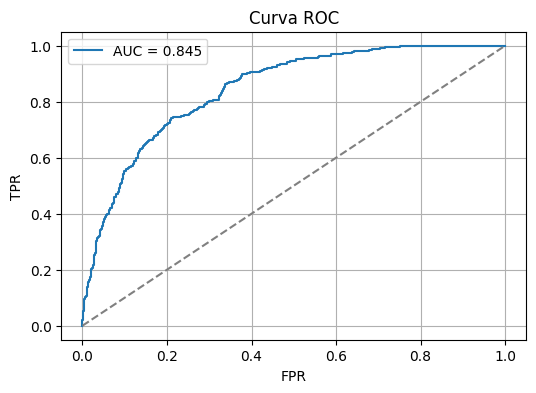

In [ ]:
# Definimos modelo 
lr = LogisticRegression()

# Entrenamiento y prediccion
lr.fit(x1_train, y1_train)
y1_pred_train = lr.predict(x1_train)
y1_pred_test = lr.predict(x1_test)

# Impresion de resultado 
evaluacion(lr, x1_train, y1_train, x1_test, y1_test, 'Regresion Logistica', resultados_modelos)


### Bosque Aleatorio

In [ ]:
# Definimos el modelo de bosque para buscar los mejores parametros
rf = RandomForestClassifier(class_weight='balanced', random_state=7)

# Definimos parametros 
rf_parameters = {'n_estimators': [200, 500],
                'max_features': [1, 2, 3, 'sqrt', 'log2'],
                'max_depth': [4, 5, 6, 7, 8],
                'criterion': ['gini', 'entropy']}

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_parameters,  
    scoring='roc_auc',
    n_jobs=5,
    cv=5,
    verbose=True
)

rf_search.fit(x3_train, y3_train)
print(rf_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 500, 'max_features': 'log2', 'max_depth': 8, 'criterion': 'gini'}


PROMEDIO ROC-AUC de ENTRENAMIENTO (K-Fold): 0.8426851283907879
ROC-AUC en TEST: 0.8481443662859592
Exactitud en TEST: 0.757640369580668


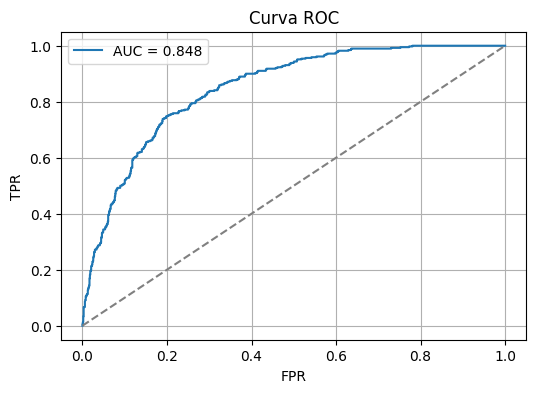

In [ ]:
# Usamos los parametros recomendados
rf = RandomForestClassifier(n_estimators=200,max_features='sqrt', max_depth=7, criterion='entropy',class_weight='balanced', random_state=7)
evaluacion(rf, x3_train, y3_train, x3_test, y3_test, 'Bosque Aleatorio', resultados_modelos)

### Catboost

In [ ]:
import os
# Ruta temporal para CatBoost
temp_dir = r'C:\Users\Usuario\catboost_tmp'
os.makedirs(temp_dir, exist_ok=True)

# Definir el modelo base
cat_cols = categorical_columns
cat = CatBoostClassifier(
    verbose=0,
    cat_features=cat_cols,        
    class_weights=[1, 5163/1869], 
    random_state=42,
    train_dir=temp_dir
)

# Parametros
cat_params = {
    'iterations': [200, 500, 800],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]}

# Busqueda aleatoria
cat_search = RandomizedSearchCV(
    estimator=cat,
    param_distributions=cat_params,
    scoring='roc_auc',
    cv=5,
    n_iter=10,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

#Entranmiento para busqueda
cat_search.fit(x2_train, y2_train)

#Imprimir mejores hiperparametros
print("Mejores hiperparámetros:", cat_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores hiperparámetros: {'learning_rate': 0.05, 'l2_leaf_reg': 7, 'iterations': 200, 'depth': 4, 'border_count': 64}


PROMEDIO ROC-AUC de ENTRENAMIENTO (K-Fold): 0.8480331094730491
ROC-AUC en TEST: 0.8515719940498702
Exactitud en TEST: 0.757640369580668


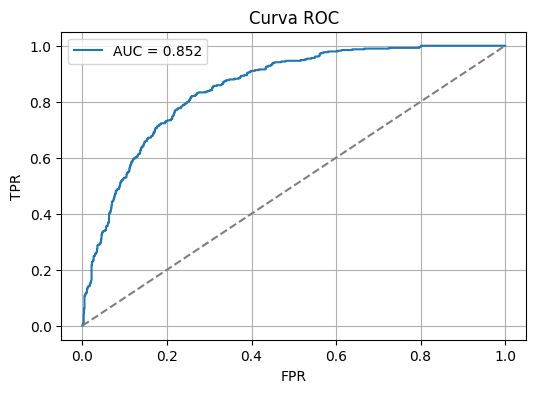

In [ ]:
import os
# Ruta temporal segura
temp_dir = r'C:\Users\Usuario\catboost_tmp'
os.makedirs(temp_dir, exist_ok=True)

cat = CatBoostClassifier(
    verbose=0,
    cat_features=cat_cols,        
    class_weights=[1, 5163/1869], 
    random_state=42,
    learning_rate=0.05,
    l2_leaf_reg=7,
    iterations=200,
    depth=4,
    border_count=64,
    train_dir=temp_dir
)
evaluacion(cat, x2_train, y2_train, x2_test, y2_test, 'Catboost', resultados_modelos)

### LightGBM 

In [ ]:
# Definimos modelo
lgbm = LGBMClassifier(class_weight='balanced', random_state=7)

# Hiperparámetros 
lgbm_params = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 50],
    'max_depth': [-1, 5, 10, 15],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Randomized Search
lgbm_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_params,
    scoring='roc_auc',
    n_iter=20,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Entrenamiento
lgbm_search.fit(x3_train, y3_train)


# Mejores hiperparámetros
print("Mejores parámetros:", lgbm_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros: {'subsample': 0.6, 'num_leaves': 50, 'n_estimators': 300, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


PROMEDIO ROC-AUC de ENTRENAMIENTO (K-Fold): 0.844129309381581
ROC-AUC en TEST: 0.8495020548117893
Exactitud en TEST: 0.7547974413646056


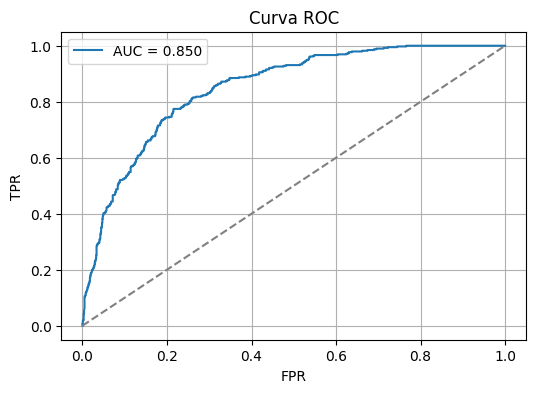

In [ ]:
# Usamos mejores hiperparametros
lgbm = LGBMClassifier(class_weight='balanced', random_state=42, subsample=0.6, num_leaves=50, n_estimators=300, min_child_samples=20, max_depth=5, learning_rate=0.01, colsample_bytree=0.8)

evaluacion(lgbm,x3_train,y3_train, x3_test, y3_test, 'LightGBM', resultados_modelos)


### XGBoost

In [ ]:
# Calculamos el peso de la clase positiva
scale_weight = 5163 / 1869  

# Modelo base
xgb = XGBClassifier(
    scale_pos_weight=scale_weight,
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)

# Hiperparámetros a explorar
xgb_params = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Randomized Search
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_params,
    scoring='roc_auc',
    n_iter=20,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Entrenamiento
xgb_search.fit(x3_train, y3_train)

# Mejores hiperparámetros
print("Mejores parámetros:", xgb_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
# Aplicamos los mejores hiperparámetros encontrados
xgb = XGBClassifier(
    scale_pos_weight=scale_weight,
    use_label_encoder=False,
    eval_metric='auc',
    random_state=7,
    n_estimators=100,
    learning_rate=.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=5,
    reg_alpha=0,
    reg_lambda=2
)

evaluacion(xgb, x3_train, y3_train, x3_test, y3_test, 'XGBoost', resultados_modelos)

### Red Neuronal

In [ ]:
# Función que construye el modelo
def crear_modelo(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(1, activation='sigmoid'))  

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    return model

# Definimos el modelo 
modelo_nn = KerasClassifier(
    build_fn=lambda: crear_modelo(x1_train.shape[1]),
    epochs=100,
    batch_size=32,
    verbose=0
)

In [ ]:
# Evaluamos el modelo de red neuronal
evaluacion(modelo_nn, x1_train, y1_train, x1_test, y1_test, 'Red Neuronal', resultados_modelos)

## Comparacion final de Modelos

In [ ]:
# Convertir lista a DataFrame
df_resultados = pd.DataFrame(resultados_modelos)

# Ordenar por ROC-AUC en test (descendente)
df_resultados = df_resultados.sort_values(by='ROC-AUC Test', ascending=False)

# Mostrar la tabla
print(df_resultados)

## Conclusiones

Con la tabla de comparacion podemos ver la calidad de los modelos, podemos observar que todos superan .84 en ROC-AUC, la regresion logistica pudo superar al bosque aleatorio por el uso de SMOTE gracias al balanceo de la clases, el modelo de red neuronal tambien se vio beneficiado de este preprocesamiento para el balanceo de las clases, varios de los modelos pueden ser optimizados buscando mejores hiperparametros o buscando mejorar en los datos, pero ya que el objetivo es buscar el mejor score de ROC-AUC nos podemos centrar en el modelo de red neuronal ya que tiene el mejor score y se podria buscar mejorar la marca de .8786 para tener un modelo que haga predicciones mejores.

# Informe de solucion

¿Qué pasos del plan se realizaron y qué pasos se omitieron (explica por qué)?

- Se realizaron todos los pasos del plan de trabajo desde el analisis exploratorio de datos, el preprocesamiento de los datos donde se dividieron los datos para el correcto entrenamiento de los modelos, se realizo la busqueda de parametros para los modelos, se definieron los modelos y se entrenaron y por ultimo se evaluaron los modelos para poder obtener las conclusiones finales.
    
¿Qué dificultades encontraste y cómo lograste resolverlas?

- Encontre algunas dificultades para comprender los datos y tambien para poder definir la codificacion y el escalamiento ya que cada modelo ofrece capacidades diferentes por lo que fue confuso definir diferentes datos para cada modelo pero esto fue de gran importancia para sacar el mayor provecho del rendimiento de los diferentes modelos

¿Cuáles fueron algunos de los pasos clave para resolver la tarea?

- Pienso que fueron 2 principalmente el preprocesamiento para la imputacion, el balanceo de clases, escalamiento y codificacion de caracteristicas categoricas y ademas de eso el buscar hiperparametros o definir en modelo en el caso de la red neuronal para que pudieramos obtener el mejor rendimiento de cada uno y escoger la mejor opcion.

¿Cuál es tu modelo final y qué nivel de calidad tiene? 

- Nuestro modelo final fue una red neuronal que tuvo una calidad muy buena casi excelente, que como se comentaba podria seguir trabajandose este modelo buscar areas de mejora para el modelo al igual que los datos.